In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas import *
import numpy as np
import plotly.express as ex
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.offline as pyo
import time
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, when, isnan, col, regexp_replace, length
from pyspark.sql.types import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=d84ea9b9a7c854d7919bec9a86a524663fba292d268dee9e3956a9d3e0895f06
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
spark = SparkSession.builder.appName("example").getOrCreate()


file_path = 'gdrive/My Drive/BigData/Final/Top2000CompaniesGlobally.csv'
data = spark.read.format("csv")\
        .option("header","true")\
        .option("inferSchema","true")\
        .load(file_path)
data.count()

Mounted at /content/gdrive


1924

In [3]:
data.show()

+-----------+--------------------+----------------+------------------+-----------------+-----------------------+---------------+-------------+----------+----------+
|Global Rank|             Company|Sales ($billion)|Profits ($billion)|Assets ($billion)|Market Value ($billion)|        Country|    Continent|  Latitude| Longitude|
+-----------+--------------------+----------------+------------------+-----------------+-----------------------+---------------+-------------+----------+----------+
|          1|                ICBC|           134.8|              37.8|           2813.5|                  237.3|          China|         Asia|  35.86166|104.195397|
|          2|China Constructio...|           113.1|              30.6|           2241.0|                  202.0|          China|         Asia|  35.86166|104.195397|
|          3|      JPMorgan Chase|           108.2|              21.3|           2359.1|                  191.4|            USA|North America|  37.09024|-95.712891|
|         

In [4]:
data.printSchema()

root
 |-- Global Rank: integer (nullable = true)
 |-- Company: string (nullable = true)
 |-- Sales ($billion): double (nullable = true)
 |-- Profits ($billion): double (nullable = true)
 |-- Assets ($billion): double (nullable = true)
 |-- Market Value ($billion): double (nullable = true)
 |-- Country: string (nullable = true)
 |-- Continent: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)



In [5]:
data.describe().show()

+-------+-----------------+--------------------+------------------+------------------+-----------------+-----------------------+---------+-------------+------------------+------------------+
|summary|      Global Rank|             Company|  Sales ($billion)|Profits ($billion)|Assets ($billion)|Market Value ($billion)|  Country|    Continent|          Latitude|         Longitude|
+-------+-----------------+--------------------+------------------+------------------+-----------------+-----------------------+---------+-------------+------------------+------------------+
|  count|             1924|                1924|              1924|              1924|             1924|                   1924|     1924|         1924|              1924|              1924|
|   mean|997.2328482328483|                NULL|19.265904365904273|1.2260395010395047|79.50779625779606|     19.558160083160104|     NULL|         NULL|34.618746549376155|15.455664304573906|
| stddev|575.5027807871161|                NU

In [ ]:
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+-----------+-------+----------------+------------------+-----------------+-----------------------+-------+---------+--------+---------+
|Global Rank|Company|Sales ($billion)|Profits ($billion)|Assets ($billion)|Market Value ($billion)|Country|Continent|Latitude|Longitude|
+-----------+-------+----------------+------------------+-----------------+-----------------------+-------+---------+--------+---------+
|          0|      0|               0|                 0|                0|                      0|      0|        0|       0|        0|
+-----------+-------+----------------+------------------+-----------------+-----------------------+-------+---------+--------+---------+



In [7]:
data.createOrReplaceTempView("data")

In [8]:
df = spark.sql("SELECT `Sales ($billion)` as Sale,`Market Value ($billion)` as MarketValue FROM data")
df.show(5)

+-----+-----------+
| Sale|MarketValue|
+-----+-----------+
|134.8|      237.3|
|113.1|      202.0|
|108.2|      191.4|
|147.4|      243.7|
|420.7|      400.4|
+-----+-----------+
only showing top 5 rows



In [10]:
df.select('Sale').distinct().orderBy('Sales ($billion)').show(10, False)

+----+
|Sale|
+----+
|0.0 |
|0.2 |
|0.3 |
|0.4 |
|0.5 |
|0.6 |
|0.7 |
|0.8 |
|0.9 |
|1.0 |
+----+
only showing top 10 rows



In [11]:
df.select('MarketValue').distinct().orderBy('Market Value ($billion)').show(10, False)

+-----------+
|MarketValue|
+-----------+
|0.0        |
|0.1        |
|0.2        |
|0.3        |
|0.4        |
|0.5        |
|0.6        |
|0.7        |
|0.8        |
|0.9        |
+-----------+
only showing top 10 rows



In [13]:
sales = df.rdd.map(lambda p: (p.Sale)).collect()

In [14]:
sale_df = DataFrame({'Sale':sales})

In [22]:
data_min = 0.0
data_max = 469.2
data_count = 1924
data_mean = 19.26
data_stddev = 34.68

# Calculate interquartile range (IQR)
q75, q25 = np.percentile(sale_df['Sale'], [75 ,25])
iqr = q75 - q25

# Calculate bin width using Freedman-Diaconis rule
bin_width = 2 * iqr / (data_count ** (1/3))

# Calculate the number of bins using the data range and bin width
num_bins = int((data_max - data_min) / bin_width)
print(num_bins)

203


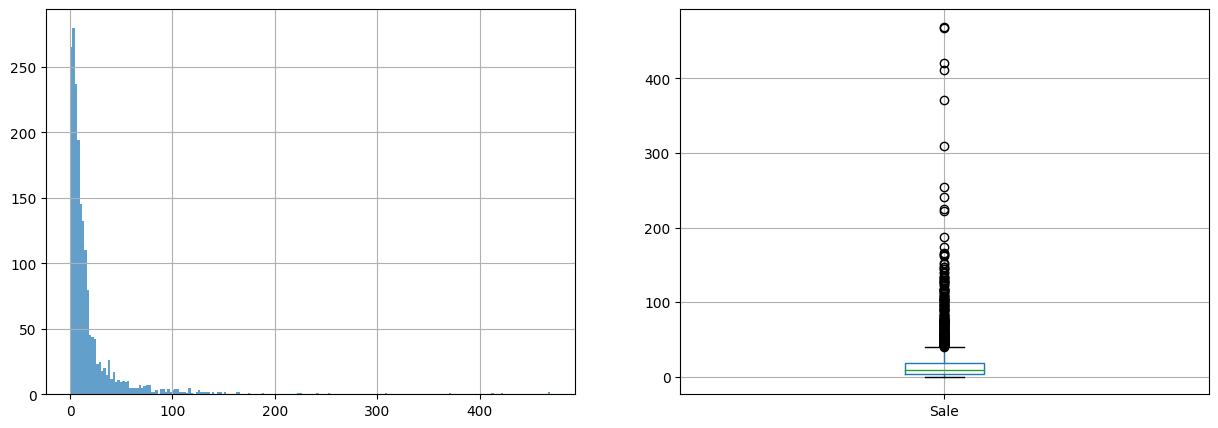

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sale_df['Sale'].hist(bins=203,ax=axes[0], alpha=0.7)
sale_df['Sale'].to_frame().boxplot(ax=axes[1], vert=True);

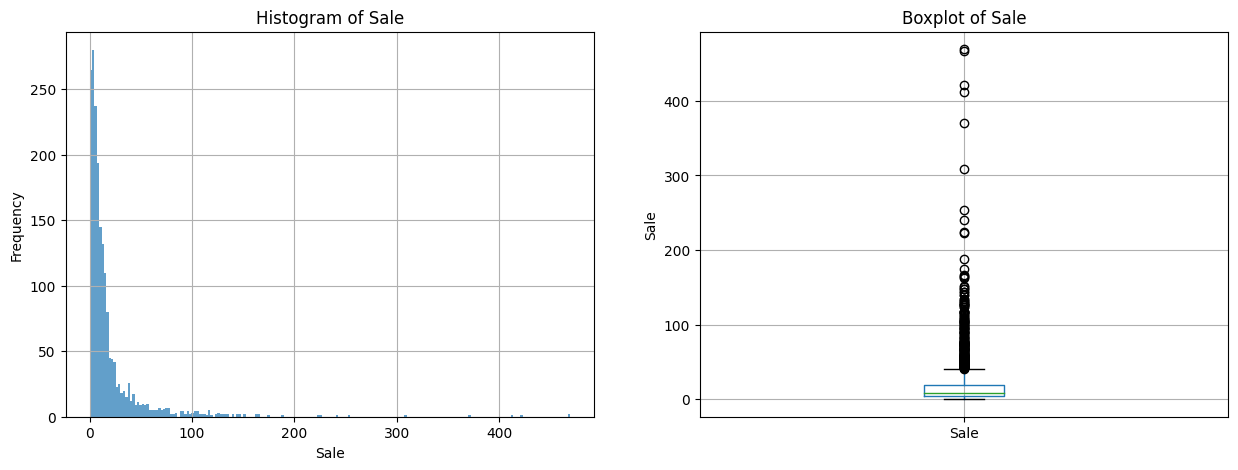

In [24]:
# Create a subplot with 1 row and 2 columns, setting the figure size to (15, 5)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot the histogram of the 'Sale' column in the first subplot (axes[0])
sale_df['Sale'].hist(bins=203, ax=axes[0], alpha=0.7)

# Plot the boxplot of the 'Sale' column in the second subplot (axes[1])
sale_df[['Sale']].boxplot(ax=axes[1], vert=True)

# Set labels for the subplots
axes[0].set_title('Histogram of Sale')
axes[0].set_xlabel('Sale')
axes[0].set_ylabel('Frequency')

axes[1].set_title('Boxplot of Sale')
axes[1].set_ylabel('Sale')

# Display the plot
plt.show()

In [25]:
market_value = df.rdd.map(lambda p: (p.MarketValue)).collect()

In [26]:
market_value_df = DataFrame({'Market_value': market_value})

In [29]:
data_min = 0.0
data_max = 416.6
data_count = 1924
data_mean = 19.558
data_stddev = 32.957

# Calculate interquartile range (IQR)
q75, q25 = np.percentile(market_value_df['Market_value'], [75 ,25])
iqr = q75 - q25

# Calculate bin width using Freedman-Diaconis rule
bin_width = 2 * iqr / (data_count ** (1/3))

# Calculate the number of bins using the data range and bin width
num_bins = int((data_max - data_min) / bin_width)
print(num_bins)

186


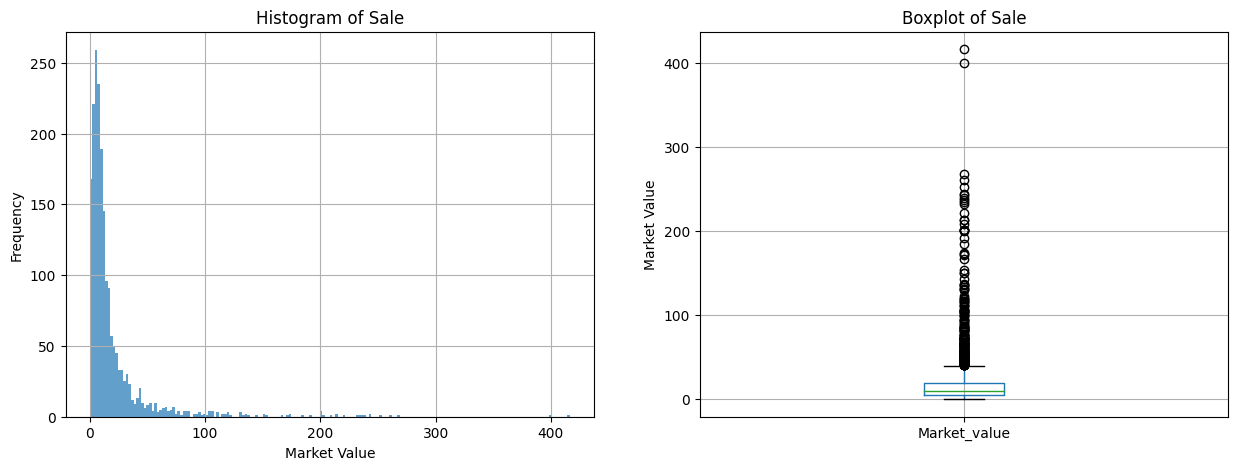

In [30]:
# Create a subplot with 1 row and 2 columns, setting the figure size to (15, 5)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot the histogram of the 'Sale' column in the first subplot (axes[0])
market_value_df['Market_value'].hist(bins=186, ax=axes[0], alpha=0.7)

# Plot the boxplot of the 'Sale' column in the second subplot (axes[1])
market_value_df[['Market_value']].boxplot(ax=axes[1], vert=True)

# Set labels for the subplots
axes[0].set_title('Histogram of Sale')
axes[0].set_xlabel('Market Value')
axes[0].set_ylabel('Frequency')

axes[1].set_title('Boxplot of Sale')
axes[1].set_ylabel('Market Value')

# Display the plot
plt.show()

### Phân tích dữ liệu

In [31]:
x = df.rdd.map(lambda p: (p.Sale)).collect()
y = df.rdd.map(lambda p: (p.MarketValue)).collect()

In [32]:
data_df = DataFrame({'Sale':x, 'MarketValue':y})

### Chuẩn bị dữ liệu

In [33]:
df.show()

+-----+-----------+
| Sale|MarketValue|
+-----+-----------+
|134.8|      237.3|
|113.1|      202.0|
|108.2|      191.4|
|147.4|      243.7|
|420.7|      400.4|
|104.9|      201.3|
|467.2|      213.1|
|103.0|      150.8|
|308.9|      261.2|
|162.5|      252.8|
| 98.1|      131.7|
| 91.2|      201.3|
|222.6|      232.5|
|254.0|       94.4|
|469.2|      242.5|
|164.7|      416.6|
|144.0|      111.4|
|370.9|      130.4|
| 90.7|      143.6|
|144.1|      120.7|
+-----+-----------+
only showing top 20 rows



In [34]:
df.createOrReplaceTempView("split_data")
X = spark.sql("SELECT DOUBLE(Sale) FROM split_data")
Y = spark.sql("SELECT DOUBLE(MarketValue) FROM split_data")

In [35]:
X.show(20)

+-----+
| Sale|
+-----+
|134.8|
|113.1|
|108.2|
|147.4|
|420.7|
|104.9|
|467.2|
|103.0|
|308.9|
|162.5|
| 98.1|
| 91.2|
|222.6|
|254.0|
|469.2|
|164.7|
|144.0|
|370.9|
| 90.7|
|144.1|
+-----+
only showing top 20 rows



In [36]:
Y.show(20)

+-----------+
|MarketValue|
+-----------+
|      237.3|
|      202.0|
|      191.4|
|      243.7|
|      400.4|
|      201.3|
|      213.1|
|      150.8|
|      261.2|
|      252.8|
|      131.7|
|      201.3|
|      232.5|
|       94.4|
|      242.5|
|      416.6|
|      111.4|
|      130.4|
|      143.6|
|      120.7|
+-----------+
only showing top 20 rows



In [37]:
# Chia dữ liệu theo tỉ lệ train:test 7:3
X_train, X_test = X.randomSplit([0.7, 0.3], seed = 2)
Y_train, Y_test = Y.randomSplit([0.7, 0.3], seed = 2)

In [38]:
X_train.describe().show()

+-------+------------------+
|summary|              Sale|
+-------+------------------+
|  count|              1325|
|   mean|18.790113207547183|
| stddev|34.781117916289176|
|    min|               0.0|
|    max|             469.2|
+-------+------------------+



In [39]:
X_test.describe().show()

+-------+-----------------+
|summary|             Sale|
+-------+-----------------+
|  count|              599|
|   mean|20.31836393989984|
| stddev|34.47352379441042|
|    min|              0.3|
|    max|            467.2|
+-------+-----------------+



In [40]:
Y_train.describe().show()

+-------+------------------+
|summary|       MarketValue|
+-------+------------------+
|  count|              1325|
|   mean|18.900000000000002|
| stddev|  31.9327848651619|
|    min|               0.0|
|    max|             416.6|
+-------+------------------+



In [41]:
Y_test.describe().show()

+-------+-----------------+
|summary|      MarketValue|
+-------+-----------------+
|  count|              599|
|   mean|21.01402337228713|
| stddev|35.10057318333682|
|    min|              0.2|
|    max|            400.4|
+-------+-----------------+

